In [365]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reintegrar rótulos no dataset principal

#Carregar tudo

In [366]:
import pandas as pd
import numpy as np

In [367]:
df = pd.read_csv("/content/drive/MyDrive/UFC /CD/pln/comentarios_tratados2.csv")
df_prisao_anot = pd.read_csv("/content/drive/MyDrive/UFC /CD/pln/data/rotulagem/anotacao_prisao.csv")
df_interv_anot = pd.read_csv("/content/drive/MyDrive/UFC /CD/pln/data/rotulagem/anotacao_intervencao.csv")


#####1.2 Merge — PRISÃO

Merge pelo comentario_id:

In [368]:
df = df.merge(
    df_prisao_anot[["comentario_id", "posicao_prisao"]],
    on="comentario_id",
    how="left",
    suffixes=("", "_novo")
)

# Check if 'posicao_prisao_novo' was created (meaning 'posicao_prisao' existed in original df)
if "posicao_prisao_novo" in df.columns:

    df["posicao_prisao"] = df["posicao_prisao_novo"].combine_first(df["posicao_prisao"])

    df.drop(columns=["posicao_prisao_novo"], inplace=True)


#####Merge intervenção

In [369]:
df = df.merge(
    df_interv_anot[["comentario_id", "posicao_intervencao"]],
    on="comentario_id",
    how="left",
    suffixes=("", "_novo")
)

# Check if 'posicao_intervencao_novo' was created
if "posicao_intervencao_novo" in df.columns:

    df["posicao_intervencao"] = df["posicao_intervencao_novo"].combine_first(df["posicao_intervencao"])
    df.drop(columns=["posicao_intervencao_novo"], inplace=True)


#####Normalizar rótulos

In [370]:
df["posicao_intervencao"] = df["posicao_intervencao"].replace({
    "CRITICO_INTERV_EUA": "CRITICA_INTERVENCAO_EUA"
})

#ACERVO

In [371]:
total_bruto = len(df)

estatisticas_bruto = pd.DataFrame({
    "Métrica": [
        "Total de comentários",
        "Associa Brasil",
        "Menciona Prisão",
        "Menciona Intervenção"
    ],
    "Quantidade": [
        total_bruto,
        df["associa_brasil"].sum(),
        df["menciona_prisao"].sum(),
        df["menciona_intervencao"].sum()
    ]
})

estatisticas_bruto["Porcentagem (%)"] = (
    estatisticas_bruto["Quantidade"] / total_bruto * 100
).round(2)

estatisticas_bruto


,Métrica,Quantidade,Porcentagem (%)
0,Total de comentários,7919,100.00
1,Associa Brasil,2193,27.69
2,Menciona Prisão,461,5.82
3,Menciona Intervenção,820,10.35


As categorias ‘associa Brasil’, ‘menciona prisão’ e ‘menciona intervenção’ não são mutuamente exclusivas. Um mesmo comentário pode pertencer simultaneamente a mais de uma categoria, razão pela qual a soma das quantidades não corresponde ao total de comentários do dataset.

In [372]:
nenhum = df[
    (df["associa_brasil"] == False) &
    (df["menciona_prisao"] == False) &
    (df["menciona_intervencao"] == False)
]

qtd = len(nenhum)
porcentagem = qtd / len(df) * 100

qtd, round(porcentagem, 2)


(4902, 61.9)

Mais de 60% dos comentários não abordam diretamente os temas políticos analisados, o que reforça a importância do pré-processamento e da filtragem temática

In [373]:
def resumo_quant_percent(df, coluna):
    total = len(df)

    resumo = (
        df[coluna]
        .value_counts(dropna=False)
        .reset_index()
    )

    resumo.columns = [coluna, "quantidade"]

    # GARANTE que quantidade é numérica
    resumo["quantidade"] = pd.to_numeric(resumo["quantidade"], errors="coerce")

    resumo["porcentagem (%)"] = (resumo["quantidade"] / total * 100).round(2)

    return resumo


##Preparar datasets finais pra treino

Dos 461 comentários que mencionam prisão, apenas 267 pertencem à amostra anotada manualmente e apresentam rótulos válidos para classificação supervisionada.

####2.1 Dataset — PRISÃO

In [374]:
df_prisao_final = df[
    (df["menciona_prisao"] == True) &
    (df["posicao_prisao"].isin(["APOIA_PRISAO", "CRITICA_PRISAO"]))
]

X_prisao = df_prisao_final["texto_limpo"]
y_prisao = df_prisao_final["posicao_prisao"]

In [375]:
tabela_prisao = resumo_quant_percent(
    df_prisao_final,
    "posicao_prisao"
)

tabela_prisao

,posicao_prisao,quantidade,porcentagem (%)
0,APOIA_PRISAO,258,96.63
1,CRITICA_PRISAO,9,3.37


In [376]:
total = len(df)

menciona_prisao = df["menciona_prisao"].sum()

anotados_prisao = df[
    (df["menciona_prisao"] == True) &
    (df["posicao_prisao"].isin([
        "APOIA_PRISAO",
        "CRITICA_PRISAO"
    ]))
]

critica_prisao = (anotados_prisao["posicao_prisao"] == "CRITICA_PRISAO").sum()
apoia_prisao = (anotados_prisao["posicao_prisao"] == "APOIA_PRISAO").sum()

# Se existir NEUTRO, opcional:
neutro_prisao = (anotados_prisao["posicao_prisao"] == "NEUTRO").sum()

tabela_funil_prisao = pd.DataFrame({
    "Etapa": [
        "Total de comentários",
        "Menciona prisão",
        "Anotados com posição",
        "Crítica à prisão",
        "Apoio à prisão"
    ],
    "Quantidade": [
        total,
        menciona_prisao,
        len(anotados_prisao),
        critica_prisao,
        apoia_prisao
    ]
})

tabela_funil_prisao["Porcentagem (%)"] = (
    tabela_funil_prisao["Quantidade"] / total * 100
).round(2)

tabela_funil_prisao


,Etapa,Quantidade,Porcentagem (%)
0,Total de comentários,7919,100.00
1,Menciona prisão,461,5.82
2,Anotados com posição,267,3.37
3,Crítica à prisão,9,0.11
4,Apoio à prisão,258,3.26


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Quantidade'].plot(kind='hist', bins=20, title='Quantidade')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Porcentagem (%)'].plot(kind='hist', bins=20, title='Porcentagem (%)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('Etapa').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='Quantidade', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Quantidade', y='Porcentagem (%)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Quantidade']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Etapa')):
  _plot_series(series, series_name, i)
  fig.legend(title='Etapa', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Quantidade')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Porcentagem (%)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Etapa')):
  _plot_series(series, series_name, i)
  fig.legend(title='Etapa', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Porcentagem (%)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Etapa')):
  _plot_series(series, series_name, i)
  fig.legend(title='Etapa', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_9['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['Quantidade'].plot(kind='line', figsize=(8, 4), title='Quantidade')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['Porcentagem (%)'].plot(kind='line', figsize=(8, 4), title='Porcentagem (%)')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_12['Etapa'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_12, x='index', y='Etapa', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['Etapa'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='Quantidade', y='Etapa', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['Etapa'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='Porcentagem (%)', y='Etapa', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

####2.1 Dataset — INTERVENÇÃO

In [377]:
df_interv_final = df[
    (df["menciona_intervencao"] == True) &
    (df["posicao_intervencao"].isin(["APOIA_INTERVENCAO_EUA", "CRITICA_INTERVENCAO_EUA"
    ]))
]

X_interv = df_interv_final["texto_limpo"]
y_interv = df_interv_final["posicao_intervencao"]


In [378]:
tabela_intervencao = resumo_quant_percent(
    df_interv_final,
    "posicao_intervencao"
)

tabela_intervencao

,posicao_intervencao,quantidade,porcentagem (%)
0,CRITICA_INTERVENCAO_EUA,181,84.19
1,APOIA_INTERVENCAO_EUA,34,15.81


In [379]:
total = len(df)

menciona_intervencao = df["menciona_intervencao"].sum()

anotados_intervencao = df[
    (df["menciona_intervencao"] == True) &
    (df["posicao_intervencao"].isin([
        "CRITICA_INTERVENCAO_EUA",
        "APOIA_INTERVENCAO_EUA"
    ]))
]

critica = (anotados_intervencao["posicao_intervencao"] == "CRITICA_INTERVENCAO_EUA").sum()
apoia = (anotados_intervencao["posicao_intervencao"] == "APOIA_INTERVENCAO_EUA").sum()

tabela_funil_intervencao = pd.DataFrame({
    "Etapa": [
        "Total de comentários",
        "Menciona intervenção",
        "Anotados com posição",
        "Crítica à intervenção (EUA)",
        "Apoio à intervenção (EUA)"
    ],
    "Quantidade": [
        total,
        menciona_intervencao,
        len(anotados_intervencao),
        critica,
        apoia
    ]
})

tabela_funil_intervencao["Porcentagem (%)"] = (
    tabela_funil_intervencao["Quantidade"] / total * 100
).round(2)

tabela_funil_intervencao


,Etapa,Quantidade,Porcentagem (%)
0,Total de comentários,7919,100.00
1,Menciona intervenção,820,10.35
2,Anotados com posição,215,2.71
3,Crítica à intervenção (EUA),181,2.29
4,Apoio à intervenção (EUA),34,0.43


##Divisão de Train / Test

Os dados foram divididos em conjuntos de treino e teste na proporção 80/20, utilizando estratificação para manter a distribuição das classes.

In [380]:
from sklearn.model_selection import train_test_split

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    X_prisao, y_prisao,
    test_size=0.2,
    random_state=42,
    stratify=y_prisao
)

X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X_interv, y_interv,
    test_size=0.2,
    random_state=42,
    stratify=y_interv
)


In [470]:
pd.DataFrame({
    "Total": y_prisao.value_counts(),
    "Treino": y_train_p.value_counts(),
    "Teste": y_test_p.value_counts()
}).fillna(0).astype(int)


,Total,Treino,Teste
posicao_prisao,,,
APOIA_PRISAO,258,206,52
CRITICA_PRISAO,9,7,2


In [382]:
pd.DataFrame({
    "Total": y_interv.value_counts(),
    "Treino": y_train_i.value_counts(),
    "Teste": y_test_i.value_counts()
}).fillna(0).astype(int)

,Total,Treino,Teste
posicao_intervencao,,,
CRITICA_INTERVENCAO_EUA,181,145,36
APOIA_INTERVENCAO_EUA,34,27,7


#Treinar modelos — BoW vs TF-IDF

In [383]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix


#### 1. PRISÃO — BoW

In [384]:
bow_prisao = Pipeline([
    ("vect", CountVectorizer(
        ngram_range=(1,2), #usa unigramas + bigramas
        min_df=5, #remove termos raros (menos de 5 docs)
        max_df=0.8 #remove termos muito comuns
    )),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

bow_prisao.fit(X_train_p, y_train_p)


Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.8, min_df=5, ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

#### 2.  Prisão - TF-IDF

In [385]:
tfidf_prisao = Pipeline([
    ("vect", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=5,
        max_df=0.8,
        sublinear_tf=True
    )),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

tfidf_prisao.fit(X_train_p, y_train_p)


Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.8, min_df=5, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

####3. INTERVENÇÃO — BoW

In [386]:
bow_interv = Pipeline([
    ("vect", CountVectorizer(
        ngram_range=(1,2),
        min_df=5,
        max_df=0.8
    )),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

bow_interv.fit(X_train_i, y_train_i)


Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.8, min_df=5, ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

####4. Intervenção - TF-IDF

In [387]:
tfidf_interv = Pipeline([
    ("vect", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=5,
        max_df=0.8,
        sublinear_tf=True
    )),
    ("clf", LogisticRegression(max_iter=1000,class_weight="balanced" ))
])

tfidf_interv.fit(X_train_i, y_train_i)


Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.8, min_df=5, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

#Métricas

In [388]:
from sklearn.metrics import classification_report
from IPython.display import display, Markdown

####PRISÃO

In [390]:
# ===== BoW – Prisão =====
display(Markdown("### **BoW – Prisão**"))

bow_prisao_report = classification_report(
    y_test_p,
    bow_prisao.predict(X_test_p),
    output_dict=True
)

df_bow_prisao = pd.DataFrame(bow_prisao_report).transpose()

df_bow_prisao = df_bow_prisao.drop(
    index=["accuracy", "macro avg", "weighted avg"],
    errors="ignore"
).round(2)

display(df_bow_prisao)

### **BoW – Prisão**

,precision,recall,f1-score,support
APOIA_PRISAO,0.96,0.88,0.92,52.0
CRITICA_PRISAO,0.00,0.00,0.00,2.0


In [391]:
# ===== TF-IDF – Prisão =====
display(Markdown("### **TF-IDF – Prisão**"))

tfidf_prisao_report = classification_report(
    y_test_p,
    tfidf_prisao.predict(X_test_p),
    output_dict=True,
    zero_division=0
)

df_tfidf_prisao = pd.DataFrame(tfidf_prisao_report).transpose()

df_tfidf_prisao = df_tfidf_prisao.drop(
    index=["accuracy", "macro avg", "weighted avg"],
    errors="ignore"
).round(2)

display(df_tfidf_prisao)


### **TF-IDF – Prisão**

,precision,recall,f1-score,support
APOIA_PRISAO,0.96,1.0,0.98,52.0
CRITICA_PRISAO,0.00,0.0,0.00,2.0


Observa-se que os modelos não conseguiram identificar a classe minoritária de crítica à prisão, devido ao forte desbalanceamento dos dados

In [457]:
df_compare_prisao = pd.concat(
    {"BoW": df_bow_prisao, "TF-IDF": df_tfidf_prisao},
    axis=1
)

display(Markdown("### **Comparação – Prisão (BoW vs TF-IDF)**"))
display(df_compare_prisao)


### **Comparação – Prisão (BoW vs TF-IDF)**

BoW                            TF-IDF                  \
               precision recall f1-score support precision recall f1-score   
APOIA_PRISAO        0.96   0.88     0.92    52.0      0.96    1.0     0.98   
CRITICA_PRISAO      0.00   0.00     0.00     2.0      0.00    0.0     0.00   

                        
               support  
APOIA_PRISAO      52.0  
CRITICA_PRISAO     2.0

In [465]:
import matplotlib.pyplot as plt

def plot_tabela_comparativa(df, titulo):
    fig, ax = plt.subplots(figsize=(7, 3))  # figura menor
    ax.axis("off")

    table = ax.table(
        cellText=df.round(2).values,
        rowLabels=df.index,
        colLabels=df.columns,
        loc="center",
        cellLoc="center",
        colWidths=[0.12] * len(df.columns)  # CONTROLA largura
    )

    table.auto_set_font_size(False)
    table.set_fontsize(4)
    table.scale(1, 1.5)

    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight="bold")
            cell.set_facecolor("#E60000")
        elif col == -1:
            cell.set_text_props(weight="bold")
            cell.set_facecolor("#E60000")
        else:
            cell.set_facecolor("#FAFAFA")

    ax.set_title(titulo, fontsize=13, weight="bold", pad=10)
    plt.tight_layout()
    plt.show()


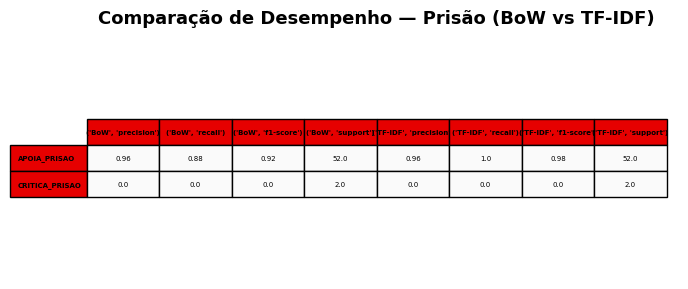

In [463]:
plot_tabela_comparativa(
    df_compare_prisao,
    "Comparação de Desempenho — Prisão (BoW vs TF-IDF)"
)


In [393]:
#Somente linhas

# print("BoW – Prisão")
# print(classification_report(y_test_p, bow_prisao.predict(X_test_p)))

# print("TF-IDF – Prisão")
# print(classification_report(y_test_p, tfidf_prisao.predict(X_test_p)))


####INTERVENÇÃO

In [394]:

display(Markdown("### **BoW – Intervenção**"))

report = classification_report(
    y_test_i,
    bow_interv.predict(X_test_i),
    output_dict=True
)

df_report = pd.DataFrame(report).transpose()

# Remove linhas que não são classes
df_report = df_report.drop(
    index=["accuracy", "macro avg", "weighted avg"],
    errors="ignore"
)

# Arredonda para 2 casas decimais
df_report = df_report.round(2)

df_report


### **BoW – Intervenção**

,precision,recall,f1-score,support
APOIA_INTERVENCAO_EUA,0.15,0.29,0.20,7.0
CRITICA_INTERVENCAO_EUA,0.83,0.69,0.76,36.0


In [395]:
display(Markdown("### **TF-IDF – Intervenção**"))

report = classification_report(
    y_test_i,
    tfidf_interv.predict(X_test_i),
    output_dict=True,
    zero_division=0
)

df_report = pd.DataFrame(report).transpose()

# Remove linhas que não são classes
df_report = df_report.drop(
    index=["accuracy", "macro avg", "weighted avg"],
    errors="ignore"
)

# Arredonda para 2 casas decimais
df_report = df_report.round(2)
df_report


### **TF-IDF – Intervenção**

,precision,recall,f1-score,support
APOIA_INTERVENCAO_EUA,0.18,0.29,0.22,7.0
CRITICA_INTERVENCAO_EUA,0.84,0.75,0.79,36.0


In [396]:
#Gerar os relatórios como DataFrame (BoW)
bow_report = classification_report(
    y_test_i,
    bow_interv.predict(X_test_i),
    output_dict=True
)

df_bow = pd.DataFrame(bow_report).transpose()

df_bow = df_bow.drop(
    index=["accuracy", "macro avg", "weighted avg"],
    errors="ignore"
).round(2)

#Gerar os relatórios como DataFrame (TF-IDF)
tfidf_report = classification_report(
    y_test_i,
    tfidf_interv.predict(X_test_i),
    output_dict=True
)

df_tfidf = pd.DataFrame(tfidf_report).transpose()

df_tfidf = df_tfidf.drop(
    index=["accuracy", "macro avg", "weighted avg"],
    errors="ignore"
).round(2)


In [397]:
#comparação direta dos dois modelos
df_compare = pd.concat(
    {"BoW": df_bow, "TF-IDF": df_tfidf},
    axis=1
)

display(Markdown("### **Comparação – Intervencao (BoW vs TF-IDF)**"))
df_compare


### **Comparação – Intervencao (BoW vs TF-IDF)**

BoW                            TF-IDF         \
                        precision recall f1-score support precision recall   
APOIA_INTERVENCAO_EUA        0.15   0.29     0.20     7.0      0.18   0.29   
CRITICA_INTERVENCAO_EUA      0.83   0.69     0.76    36.0      0.84   0.75   

                                          
                        f1-score support  
APOIA_INTERVENCAO_EUA       0.22     7.0  
CRITICA_INTERVENCAO_EUA     0.79    36.0

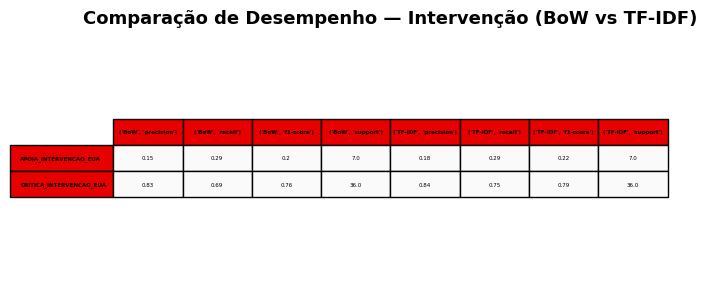

In [466]:
plot_tabela_comparativa(
    df_compare,
    "Comparação de Desempenho — Intervenção (BoW vs TF-IDF)"
)

In [398]:
#somente linhas

# print("BoW – Intervenção")
# print(bow_interv_report_str)

# print("TF-IDF – Intervenção")
# print(tfidf_interv_report_str)

####Ajustar stopwords

In [399]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
stopwords_pt = set(stopwords.words("portuguese"))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [400]:
stopwords_extra = {
    "vai", "ta", "to", "pq", "pra", "pro",
    "aí", "nao", "aqui", "lá", "agora",
    "video", "canal"
}

stopwords_final = stopwords_pt.union(stopwords_extra)


In [401]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def gerar_wordcloud(textos, titulo):
    wc = WordCloud(
        width=900,
        height=400,
        background_color="white",
        stopwords=stopwords_final,
        collocations=False
    ).generate(" ".join(textos))

    plt.figure(figsize=(12,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(titulo)
    plt.show()


####TOP TERMOS + FREQUÊNCIA

In [402]:
def top_termos(textos, vectorizer, top_n=20):
    X = vectorizer.fit_transform(textos)

    termos = vectorizer.get_feature_names_out()
    freq = np.asarray(X.sum(axis=0)).flatten()

    df_freq = pd.DataFrame({
        "termo": termos,
        "frequencia": freq
    }).sort_values(by="frequencia", ascending=False)

    return df_freq.head(top_n)


#####Apoia_Prisao

In [403]:
vect_bow = CountVectorizer(
    ngram_range=(1,2),
    min_df=1,
    max_df=1.0,
    stop_words=list(stopwords_final) #converte o conjunto em lista
)
#Top 5 termos dos comentários que apoiam prisão
top_termos(
    df_prisao_final[
        df_prisao_final["posicao_prisao"] == "APOIA_PRISAO"
    ]["texto_limpo"],
    vect_bow,
    top_n=5
)

,termo,frequencia
3144,maduro,103
4393,prisao,101
673,cadeia,76
3077,lula,61
4301,prender,43


#####Critica_Prisao

In [404]:
#Top 5 termos dos comentários q crítica prisão

top_termos(
    df_prisao_final[
        df_prisao_final["posicao_prisao"] == "CRITICA_PRISAO"
    ]["texto_limpo"],
    vect_bow,
    top_n=5
)


,termo,frequencia
110,maduro,6
102,lula,5
29,brasil,5
162,prender,5
230,trump,4


#####Apoia_Intervencao

In [405]:
#Top 5 termos de quem crítica intervenção dos EUA
top_termos(
    df_interv_final[
        df_interv_final["posicao_intervencao"] == "APOIA_INTERVENCAO_EUA"
    ]["texto_limpo"],
    vect_bow,
    top_n=5
)


,termo,frequencia
253,eua,22
418,maduro,13
793,venezuela,10
775,unidos,7
549,parabens,7


#####Critica_Intervencao

In [406]:
#Top 5 termos de quem crítica intervenção dos EUA
top_termos(
    df_interv_final[
        df_interv_final["posicao_intervencao"] == "CRITICA_INTERVENCAO_EUA"
    ]["texto_limpo"],
    vect_bow,
    top_n=5
)


,termo,frequencia
1733,eua,109
1697,estados,68
5176,venezuela,65
5006,unidos,65
1700,estados unidos,64


#Plotagem

###TOP_TERMOS

#### APOIA_PRISAO - Gráfico dos Top Termos - APOIA_PRISAO

In [407]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_terms(df_top_terms, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='frequencia', y='termo', data=df_top_terms, palette='viridis')
    plt.title(title)
    plt.xlabel('Frequência')
    plt.ylabel('Termo')
    plt.tight_layout()
    plt.show()

/tmp/ipython-input-4120755263.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequencia', y='termo', data=df_top_terms, palette='viridis')


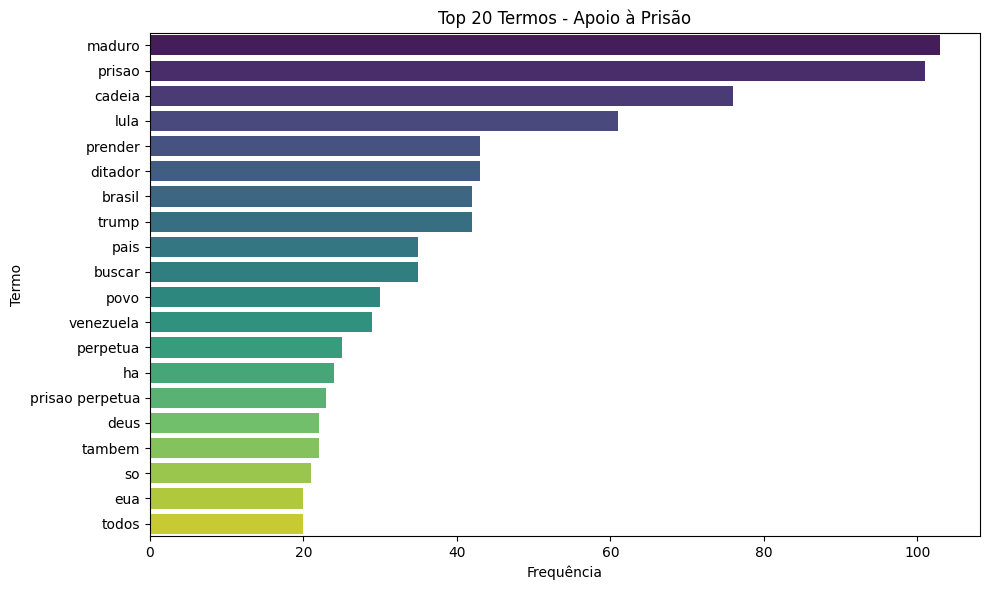

In [408]:
df_top_prisao_apoio = top_termos(
    df_prisao_final[
        df_prisao_final["posicao_prisao"] == "APOIA_PRISAO"
    ]["texto_limpo"],
    vect_bow,
    top_n=20
)
plot_top_terms(df_top_prisao_apoio, "Top 20 Termos - Apoio à Prisão")

#### CRITICA_PRISAO - Gráfico dos Top Termos - CRITICA_PRISAO

/tmp/ipython-input-4120755263.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequencia', y='termo', data=df_top_terms, palette='viridis')


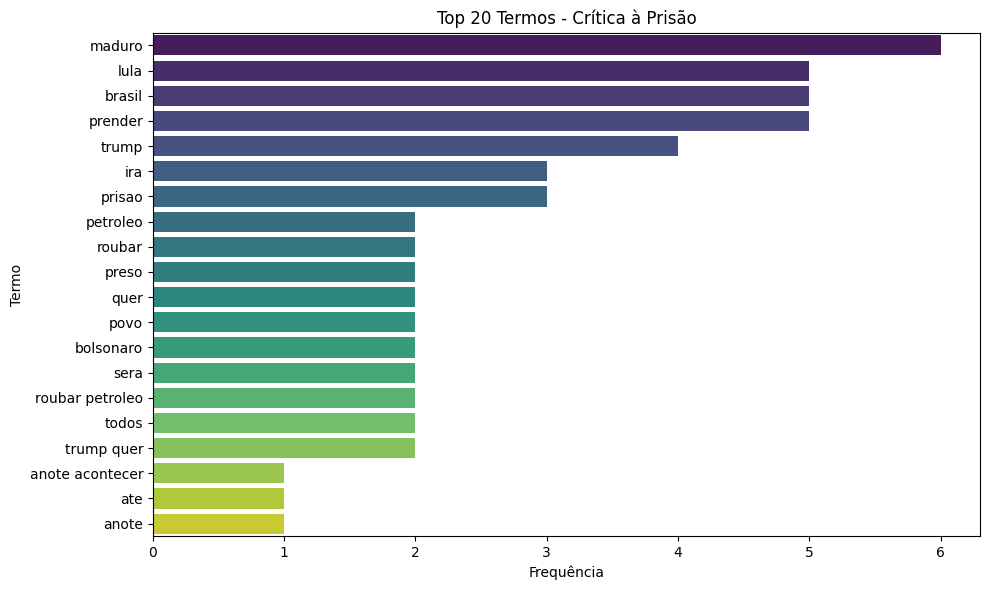

In [409]:
df_top_prisao_critica = top_termos(
    df_prisao_final[
        df_prisao_final["posicao_prisao"] == "CRITICA_PRISAO"
    ]["texto_limpo"],
    vect_bow,
    top_n=20
)
plot_top_terms(df_top_prisao_critica, "Top 20 Termos - Crítica à Prisão")

#### APOIA_INTERVENCAO_EUA - Gráfico dos Top Termos

/tmp/ipython-input-4120755263.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequencia', y='termo', data=df_top_terms, palette='viridis')


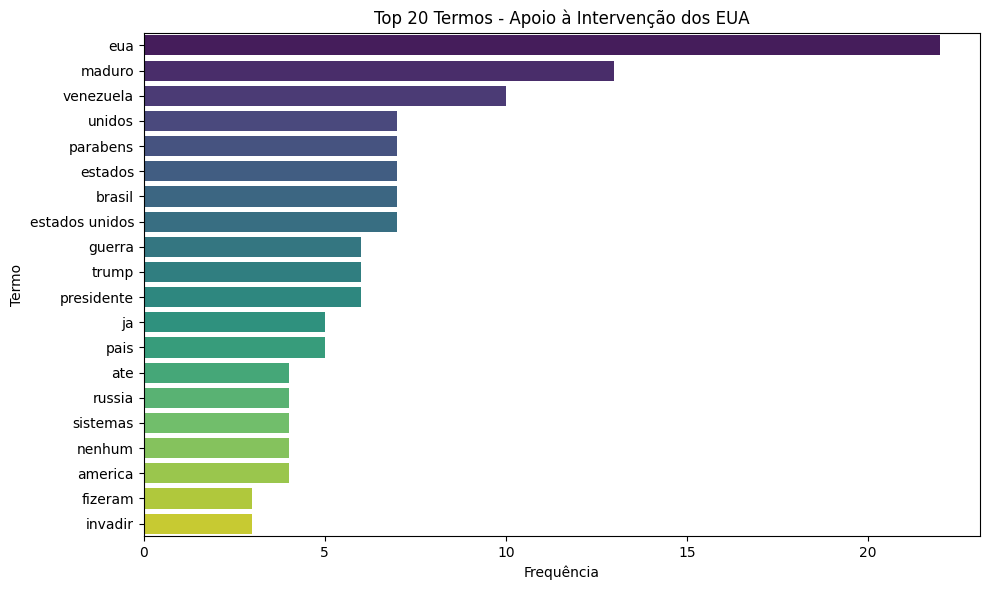

In [410]:
df_top_interv_apoio = top_termos(
    df_interv_final[
        df_interv_final["posicao_intervencao"] == "APOIA_INTERVENCAO_EUA"
    ]["texto_limpo"],
    vect_bow,
    top_n=20
)
plot_top_terms(df_top_interv_apoio, "Top 20 Termos - Apoio à Intervenção dos EUA")

#### CRITICA_INTERVENCAO_EUA - Gráfico dos Top Termos

/tmp/ipython-input-4120755263.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequencia', y='termo', data=df_top_terms, palette='viridis')


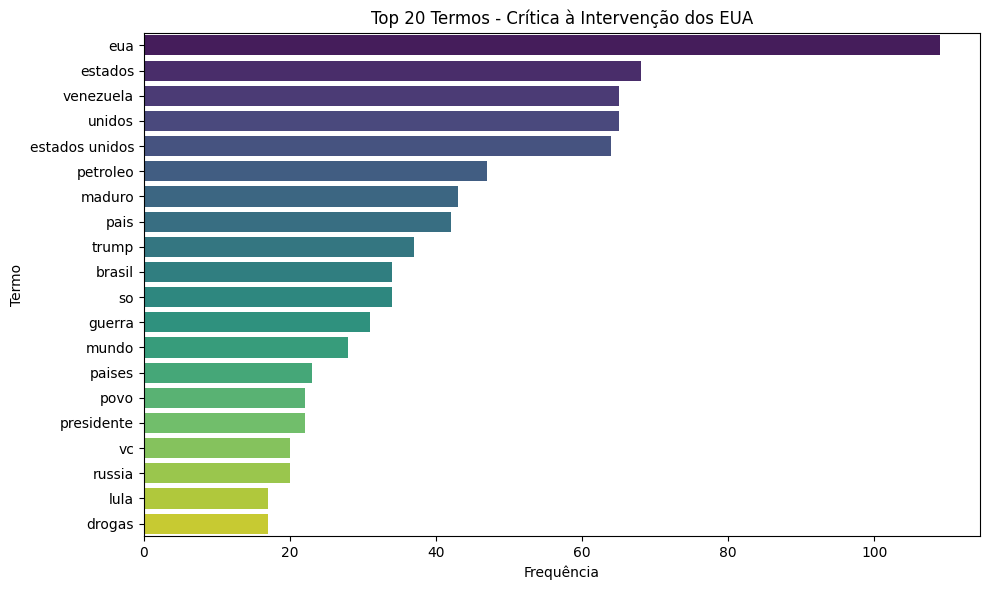

In [411]:
df_top_interv_critica = top_termos(
    df_interv_final[
        df_interv_final["posicao_intervencao"] == "CRITICA_INTERVENCAO_EUA"
    ]["texto_limpo"],
    vect_bow,
    top_n=20
)
plot_top_terms(df_top_interv_critica, "Top 20 Termos - Crítica à Intervenção dos EUA")

##Nuvens de palavras

In [412]:
!pip install wordcloud


In [413]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [414]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def gerar_wordcloud(textos, titulo):
    wc = WordCloud(
        width=900,
        height=400,
        background_color="white",
        stopwords=stopwords_final,
        collocations=False
    ).generate(" ".join(textos))

    plt.figure(figsize=(12,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(titulo)
    plt.show()


In [415]:
def gerar_wordcloud(textos, titulo):
    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        stopwords=stopwords_final,
        collocations=False
    ).generate(" ".join(textos))

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(titulo)
    plt.show()


####Prisão

- Apoio

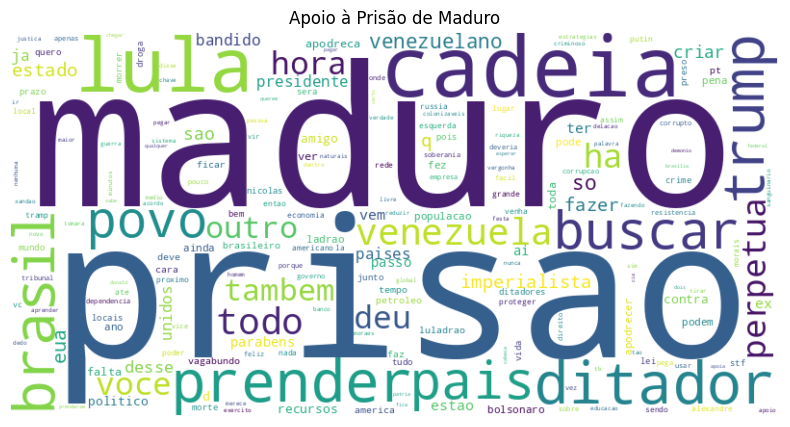

In [416]:
gerar_wordcloud(
    df_prisao_final[df_prisao_final["posicao_prisao"] == "APOIA_PRISAO"]["texto_limpo"],
    "Apoio à Prisão de Maduro"
)


- Crítica

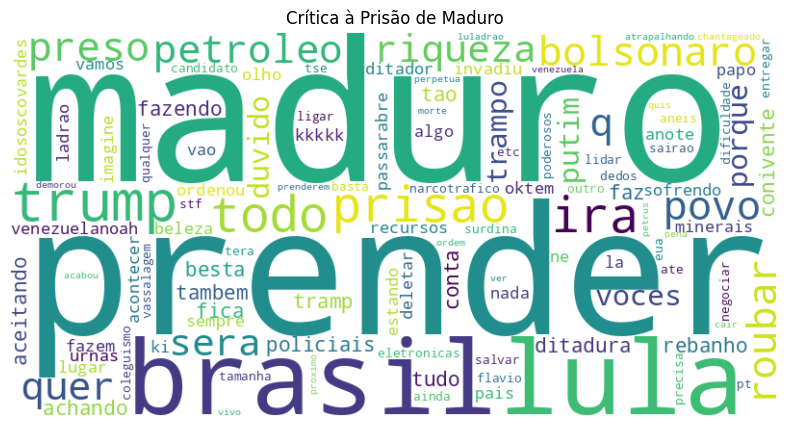

In [417]:
gerar_wordcloud(
    df_prisao_final[df_prisao_final["posicao_prisao"] == "CRITICA_PRISAO"]["texto_limpo"],
    "Crítica à Prisão de Maduro"
)


####Intervenção

- Apoio

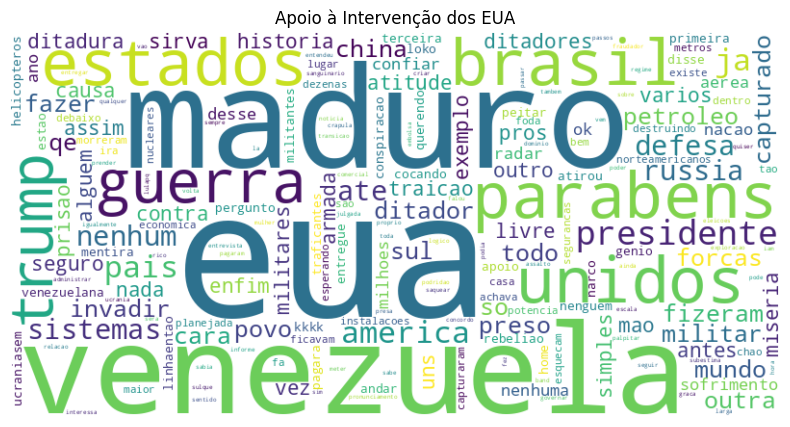

In [418]:
gerar_wordcloud(
    df_interv_final[df_interv_final["posicao_intervencao"] == "APOIA_INTERVENCAO_EUA"]["texto_limpo"],
    "Apoio à Intervenção dos EUA"
)


- Crítica

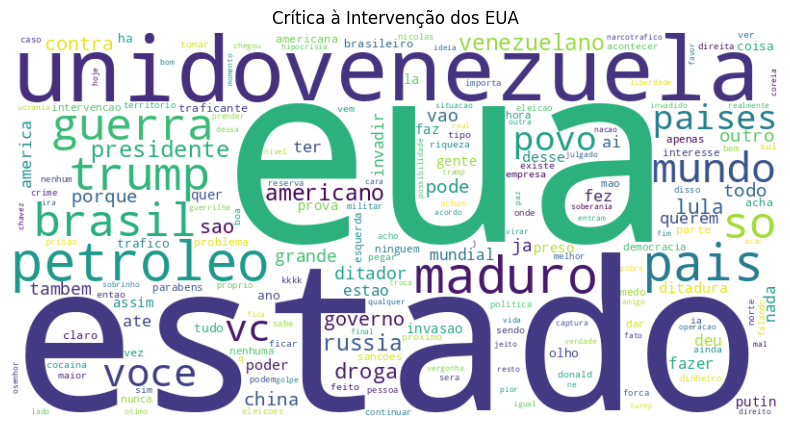

In [419]:

gerar_wordcloud(
    df_interv_final[df_interv_final["posicao_intervencao"] == "CRITICA_INTERVENCAO_EUA"]["texto_limpo"],
    "Crítica à Intervenção dos EUA"
)